# STARE server functions demonstration
Use STARE indices that have been computed for two datasets to determine if two datasets have data that intersect geographically and, if so, return the intersecting region. This demonstration also shows how to call the functions using simple python operations. 

To help clarify the roles of the two datasets, lets call the first dataset 'the dataset' and the second dataset - the source of the region we want to use for the subset - the 'target dataset' or 'target.'



## Configuration
To set up an environment for this notebook, see the `environment.yml` file (but note I have not tested that, it's based on notes I took while working on this notebook). You will need to set the environment variable USE_OMP to zero (`export USE_OMP=0`) to get one of the packages to install on OSX. In addition, you will need to install `pystare`. To do that,
I used the code straight from GitHub. 
1. Checkout pystare frim github.com/SpatioTemporal/pystare;
2. Run `pip install --editable pystare`.

In [1]:
# The requests package provides a high-level interface to HTTP/S
import requests

import h5py
import pystare as ps
import numpy

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import cartopy
import cartopy.crs as ccrs

ImportError: dlopen(/Users/jimg/opt/anaconda3/envs/opendap/lib/python3.9/site-packages/cartopy/_crs.cpython-39-darwin.so, 2): Symbol not found: _pj_free
  Referenced from: /Users/jimg/opt/anaconda3/envs/opendap/lib/python3.9/site-packages/cartopy/_crs.cpython-39-darwin.so
  Expected in: flat namespace
 in /Users/jimg/opt/anaconda3/envs/opendap/lib/python3.9/site-packages/cartopy/_crs.cpython-39-darwin.so

Some helper functions for plotting & printing.

In [182]:
def add_coastlines(figax, set_global=False):
    ax = figax[1]
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def stare_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,show=True
        ,color='xkcd:blue'
        ):

    if figax is None:
        fig,ax = plt.subplots(1, subplot_kw=plot_options)
        ax.set_global()
        ax.coastlines()
        figax = [fig,ax]
    else:
        ax = figax[1]
    
    if spatial_index_values is not None:
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        siv_triang = tri.Triangulation(lons, lats, intmat)
        ax.triplot(siv_triang, color=color, transform=plot_options['transform'])
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

# Return the last five bits of the s_index
def res_b(i):
    return bin(i)[-5:]

#return the resolution level as an integer
def res(i):
    return int(bin(i)[-5:],2)

km  = 1 # Unit of length
deg = 1 # Unit of angle

Read the indices from the 'target' sample file - there are only 121 indices in this sample.

In [183]:
f = h5py.File('MYD09.A2019003_hacked_stare.h5', 'r')

In [184]:
s_index = f['Stare_Index']

In [185]:
print(list(map(hex16,s_index[0:10])))

['0x2fbd64e77f92dbdb', '0x2fbd64e7add7a2bb', '0x2fbd64e60d8773db', '0x2fbd64faf9f99fdb', '0x2fbd64fb9c2a00fb', '0x2fbd64fb0e1b8e9b', '0x2fbd64f6780f351b', '0x2fbd64f7c2c6451b', '0x2fbd64f6992ad69b', '0x2fbd648898695e1b']


In [186]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

## Investigate the sample data

### Plot the dataset's **level 27** STARE indices
This is the highest resoltuion supported by STARE. This is the geographic location of the data.

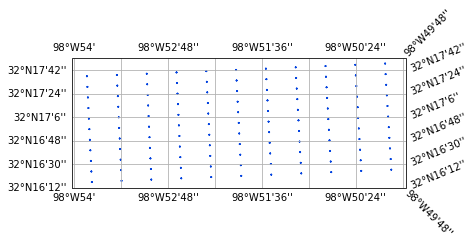

In [187]:
figax = add_coastlines(plt.subplots(1, subplot_kw=plot_options))

# figax[1].set_extent([-100, -6, 31, 34], ccrs.PlateCarree())
figax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

figax = stare_plot(s_index, figax, show=True)


### Plot the **level 14** STARE indices
The level was determined by the sidecar builder code by looking at the geospatial spacing of the data.

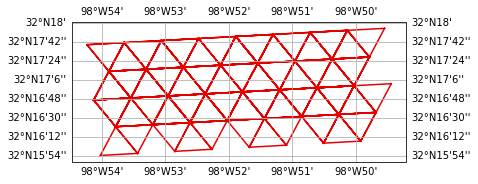

In [188]:
figax_res = add_coastlines(plt.subplots(1, subplot_kw=plot_options))

# figax[1].set_extent([-100, -6, 31, 34], ccrs.PlateCarree())
figax_res[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

f_res = h5py.File('MYD09.A2019003_hacked_stare_res.h5', 'r')
s_index_res = f_res['Stare_Index']

figax_res = stare_plot(s_index_res, figax_res, show=True, color='xkcd:red')



### We can see that the stare indices with the resolution set are different values

In [189]:
print(list(map(hex16,s_index[0:3])))

['0x2fbd64e77f92dbdb', '0x2fbd64e7add7a2bb', '0x2fbd64e60d8773db']


In [190]:
print(list(map(hex16,s_index_res[0:3])))

['0x2fbd64e77f92dbce', '0x2fbd64e7add7a2ae', '0x2fbd64e60d8773ce']


In [191]:
print(bin(s_index_res[0]))

0b10111110111101011001001110011101111111100100101101101111001110


In [192]:
# Just the resolution bits, in binary
print(res_b(s_index[1]))

11011


### Lets look at the resolution levels. 
The data pixels are spaced at a resolution of level 14, while the full resolution indices are at level 27, as expected.

In [193]:
print(res(s_index[1]))

27


In [194]:
print(res(s_index_res[1]))

14


### Plot both plain *level 27* and *level 27 with resolution set*

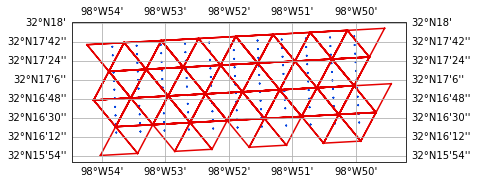

In [195]:
figax_combined = add_coastlines(plt.subplots(1, subplot_kw=plot_options))

# figax[1].set_extent([-100, -6, 31, 34], ccrs.PlateCarree())
figax_combined[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# f_res = h5py.File('MYD09.A2019003_hacked_stare_res.h5', 'r')
# s_index_res = f_res['Stare_Index']

# figax_combined = stare_plot(s_index_res, figax_combined, show=True, color='xkcd:red')
figax_combined = stare_plot(s_index, figax_combined, show=False, color='xkcd:blue')
figax_combined = stare_plot(s_index_res, figax_combined, show=True, color='xkcd:red')


### Read the target STARE indices, both plain *level 27* and *level 27 with resolution bits*

In [196]:
target = h5py.File('Target_overlap_nw_stare.h5', 'r')
target_index = target['Stare_Index']

# Just to make sure we have the indices
print(list(map(hex16, source_index[0:3])))

target_res = h5py.File('Target_overlap_nw_stare_res.h5', 'r')
target_index_res = target_res['Stare_Index']

# Just to make sure we have the indices
print(list(map(hex16, target_index_res[0:3])))

print(res(target_index[1]))
print(res(target_index_res[1]))

['0x2fbd2b00c0895f3b', '0x2fbd648103b6b0fb', '0x2fbd6484e93e459b']
['0x2fbd2b00c0895f2e', '0x2fbd648103b6b0ee', '0x2fbd6484e93e458e']
27
14


### Here's how the dataset and target region overlap
The target region we are looking for is shown in pink; the dataset we are querting is shown in red

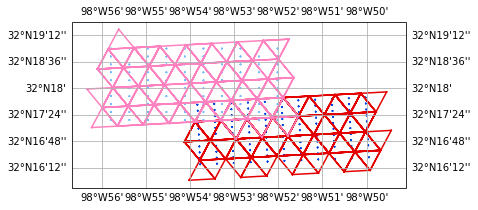

In [197]:
combined = add_coastlines(plt.subplots(1, subplot_kw=plot_options))

combined[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Remove the level 27 indices.
combined = stare_plot(s_index, combined, show=False, color='xkcd:blue')
combined = stare_plot(s_index_res, combined, show=False, color='xkcd:red')
combined = stare_plot(target_index, combined, show=False, color='xkcd:sky blue')
combined = stare_plot(target_index_res, combined, show=False, color='xkcd:pink')

plt.show()

## Calling the server functions

We will use the *intersection()*, *count()*, and *subset()* functions in the following three examples.

* *intersection()* returns true when the dataset has at least one index within the taget region.
* *count()* returns the number of STARE indices in common between the dataset and the target region.
* *subset()* returns two sets of STARE indices and the dataset indices of the data values corresponding to the subset so those values can be accessed.

### Call the server intersection() function from within python
Lets determine if the dataset holds any data in the target region

* First read the target indices
* Build the constriant
* Use the Requests package to run the function and get the results as CSV data
* Unpack the results

In the following, the some cells have python code that can be uncommented to reveal interim values

In [205]:
# The indices from the target data, read using h5py from the target sidecar file.

f = h5py.File('Target_overlap_nw_stare.h5', 'r')

# Printing the 'keys' shows the variables in an HDF5 file
# print(f.keys())

target = f['Stare_Index'][:]

# Uncomment the line below to see the first few STARE indices in the target file
# print(target[0::9])

In [206]:
# Now formualate an OPeNDAP request using the intersection() server function

dataset = 'http://localhost:8080/opendap/data/stare/MYD09.A2019003_hacked.h5'

# Build the CE info for the requests package. The call to join builds a string of values
# that are then sliced into the function call.
params_1 = {'dap4.function':'stare_intersection("data",$UInt64(0:%s))' % ','.join(str(x) for x in target)}

# This performs the request and gets the resulting intersecting STARE indices back.
r = requests.post(dataset + '.dap.csv', params_1)

In [207]:
# Uncomment to see the return result
# print(r.text)

# The result is a text response with newline separated info.
ss = r.text.split("\n")

# print(ss)

# Drop item 0 and then turn the remaining items (strings) into lists.
ss = ss[1:]

# For this result, we need only the first response. Remove the leading element.
intersection_result = ss[0].split(',')[1:]

# Here we can see that te dataset and target do indeed overlap

if int(intersection_result[0]) > 0:
    print("Yes, the regions overlap")
else:
    print("No, there is no overlap")
    

Yes, the regions overlap


### Call the server count() function from within python
Lets determine how many STARE indices the dataset target region intersect.

* Use the target indices and datset URL from above
* Build the constriant
* Use the Requests package to run the function and get the results as CSV data
* Unpack the results

In the following, the some cells have python code that can be uncommented to reveal interim values

In [208]:
# Build the CE info for the requests package. The call to join builds a string of values
# that are then sliced into the function call.
params_2 = {'dap4.function':'stare_count("data",$UInt64(0:%s))' % ','.join(str(x) for x in target)}

# This performs the request and gets the resulting intersecting STARE indices back.
r = requests.post(dataset + '.dap.csv', params_2)

In [209]:
# Uncomment to see the return result
# print(r.text)

# The result is a text response with newline separated info.
ss = r.text.split("\n")

# Drop item 0 and then turn the remaining four items (strings) into lists.
ss = ss[1:]

# For this result, we need only the first part of the response. 
# Remove the leading element.
count_result = ss[0].split(',')[1:]

# Here we can see that te dataset and target do indeed overlap

print(count_result[0])

 26


### Call the server *subset()* function from within python
Call the *subset()* function to get the dataset and target indices (they may be different because of differing resolution) and the corresponding indices of data values. See subset_array() for the function that returns (only) the data values.

* First read the target indices
* Build the constriant
* Use the Requests package to run the function and get the results as CSV data
* Unpack the results and plot

*In the following, the some cells have python code that can be uncommented to reveal interim values*

In [210]:
# dataset = 'http://localhost:8080/opendap/data/stare/MYD09.A2019003_hacked.h5'

# Build the CE info for the requests package. The call to join builds a string of values
# that are then sliced into the function call.
params_3 = {'dap4.function':'stare_subset("data",$UInt64(0:%s))' % ','.join(str(x) for x in target)}

# This performs the request and gets the resulting intersecting STARE indices back.
r = requests.post(dataset + '.dap.csv', params_3)

ss = r.text.split("\n")

# Drop item 0 and then turn the remaining items (strings) into lists, droping the first item in each of those
ss = ss[1:]

# The 'dataset' values come first the subset() function response, then the part of the target that matched.
dataset_s = ss[0].split(',')[1:]
target_s = ss[1].split(',')[1:]

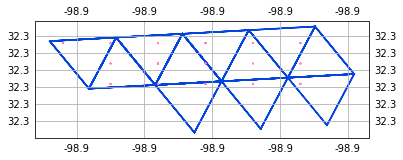

In [211]:
ss_plot = add_coastlines(plt.subplots(1, subplot_kw=plot_options))

grid_lines = ss_plot[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

dec_format = mpl.ticker.FuncFormatter(lambda v, pos:round(v*10)/10)
grid_lines.xformatter = dec_format
grid_lines.yformatter = dec_format

ss_plot = stare_plot(dataset_s, ss_plot, show=False, color='xkcd:blue')

ss_plot = stare_plot(target_s, ss_plot, show=False, color='xkcd:pink')

plt.show()